# Machine Learning Engineer NanoDegree
## Capstone Project

### Robots and surface recognition

Autonomous mobile robots who can move and perform tasks without human intervention, should be able to recognize the type of surface they are moving on. This was the task a group of researchers attempted to train robots to do. They supplied robots with IMU sensors that keep data on their orientation, angular velocity and linear acceleration. The task is to classify the surface the robot is moving on using the sensor data. 

As we will see below the sensor data are time series of 128-unit steps for each series. There are many ways to classify time series. I choose to do this using deep neural networks. 

In [ ]:
# lead necessary libraries/modules
import keras #with tensorflow backnend
import numpy as np
import pandas as pd

from keras.utils import np_utils
from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Sequential, Input, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.layers import GlobalAveragePooling1D, AveragePooling1D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, ELU
from keras import regularizers, activations, initializers
from keras import layers, optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping  


from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import confusion_matrix, fbeta_score


import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy as sp

# Pretty display for notebooks
%matplotlib inline


from sklearn.metrics.classification import (_check_targets, _prf_divide,
                                            precision_recall_fscore_support)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.multiclass import unique_labels

from sklearn.base import BaseEstimator
from sklearn.externals import six
from sklearn.utils.multiclass import check_classification_targets

from sklearn.metrics import confusion_matrix, fbeta_score, f1_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, auc

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import partial_dependence #partial_dependence.parital_dependance
                                                #partial_dependence.plot_partial_dependence

from statsmodels.tsa import stattools


print(sns.__version__)

In [2]:
# read in train and test sensor data
data_train = pd.read_csv('X_train.csv')
data_test = pd.read_csv('X_test.csv')
print('Shape of X_train dataset: ', data_train.shape, 'Shape of X_test : ', data_test.shape)
data_train.head()

Shape of X_train dataset:  (487680, 13) Shape of X_test :  (488448, 13)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [34]:
# get full info on each variable
data_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
row_id                   487680 non-null object
series_id                487680 non-null int64
measurement_number       487680 non-null int64
orientation_X            487680 non-null float64
orientation_Y            487680 non-null float64
orientation_Z            487680 non-null float64
orientation_W            487680 non-null float64
angular_velocity_X       487680 non-null float64
angular_velocity_Y       487680 non-null float64
angular_velocity_Z       487680 non-null float64
linear_acceleration_X    487680 non-null float64
linear_acceleration_Y    487680 non-null float64
linear_acceleration_Z    487680 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 74.3 MB


In [99]:
#targets 
y_train = pd.read_csv('y_train.csv')
print('Shape of y_train : ',y_train.shape)
y_train.head()

Shape of y_train :  (3810, 3)


,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [4]:
# frequency counts per surface
y_train['surface'].value_counts()

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

In [33]:
# making sense of the group_id variable
y_train.groupby('group_id')['surface'].unique()

group_id
0                   [concrete]
1                      [tiled]
2                       [wood]
3                   [soft_pvc]
4                 [soft_tiles]
5                   [concrete]
6                   [soft_pvc]
7                     [carpet]
8                      [tiled]
9                 [soft_tiles]
10                      [wood]
11                     [tiled]
12                  [concrete]
13             [fine_concrete]
14                      [wood]
15                [soft_tiles]
16    [hard_tiles_large_space]
17                [soft_tiles]
18                  [soft_pvc]
19                  [soft_pvc]
20                  [concrete]
21                [soft_tiles]
22                [soft_tiles]
23                      [wood]
24                      [wood]
25                    [carpet]
26                  [soft_pvc]
27                [hard_tiles]
28                     [tiled]
29                  [soft_pvc]
                ...           
43                      [wood]

In [ ]:
y_train.groupby('group_id')['surface'].unique().count()

In [9]:
y_train.groupby('surface')['group_id'].unique()

surface
carpet                                                      [25, 7, 60, 52]
concrete                  [31, 20, 12, 32, 0, 5, 62, 41, 42, 61, 57, 47,...
fine_concrete                                  [13, 35, 30, 68, 72, 36, 48]
hard_tiles                                                             [27]
hard_tiles_large_space                                 [33, 16, 59, 40, 44]
soft_pvc                  [34, 26, 3, 29, 19, 18, 6, 69, 70, 56, 53, 51,...
soft_tiles                                           [22, 21, 9, 15, 4, 17]
tiled                                    [1, 11, 8, 28, 71, 55, 54, 64, 66]
wood                        [23, 14, 10, 2, 24, 45, 49, 46, 38, 43, 65, 67]
Name: group_id, dtype: object

From the above we conclude that for each group_id correspond to only one surface and each surface has several group_ids
as if the researcher grouped sessions that were done together as one group. 

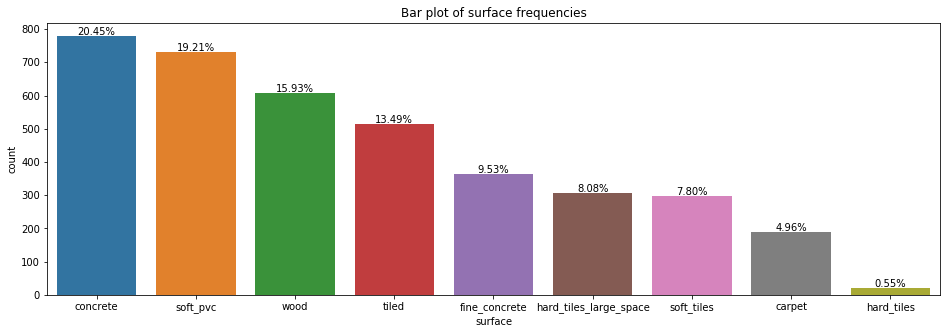

In [14]:
# bar plot of the target. 
# code borrowed from https://www.kaggle.com/gpreda/robots-need-help 

fig, ax = plt.subplots(figsize=(16,5))
total = len(y_train)
g = sns.countplot(x=y_train['surface'], order = y_train['surface'].value_counts().index)
g.set_title('Bar plot of surface frequencies')
for p in ax.patches:
    ht = p.get_height()
    ax.text(p.get_x() + p.get_width() /2, ht+3,
            '{:1.2f}%'.format(100*ht/total),
            ha="center") 
    

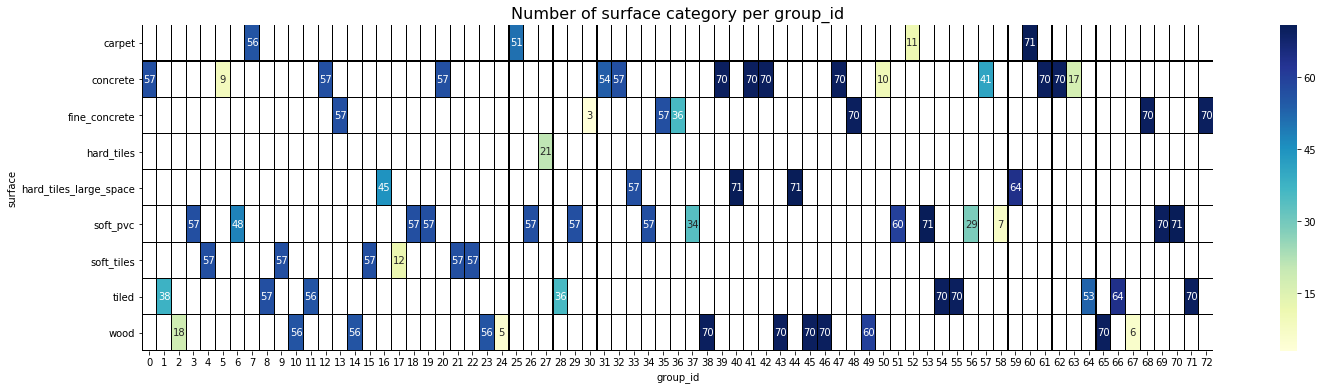

In [15]:
# A plot of surface per group_id and the count of measurements/sessions per group_id
# code from https://www.kaggle.com/gpreda/robots-need-help

fig, ax = plt.subplots(1,1,figsize=(24,6))
tmp = pd.DataFrame(y_train.groupby(['group_id', 'surface'])['series_id'].count().reset_index())
m = tmp.pivot(index='surface', columns='group_id', values='series_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of surface category per group_id', size=16)
plt.show()

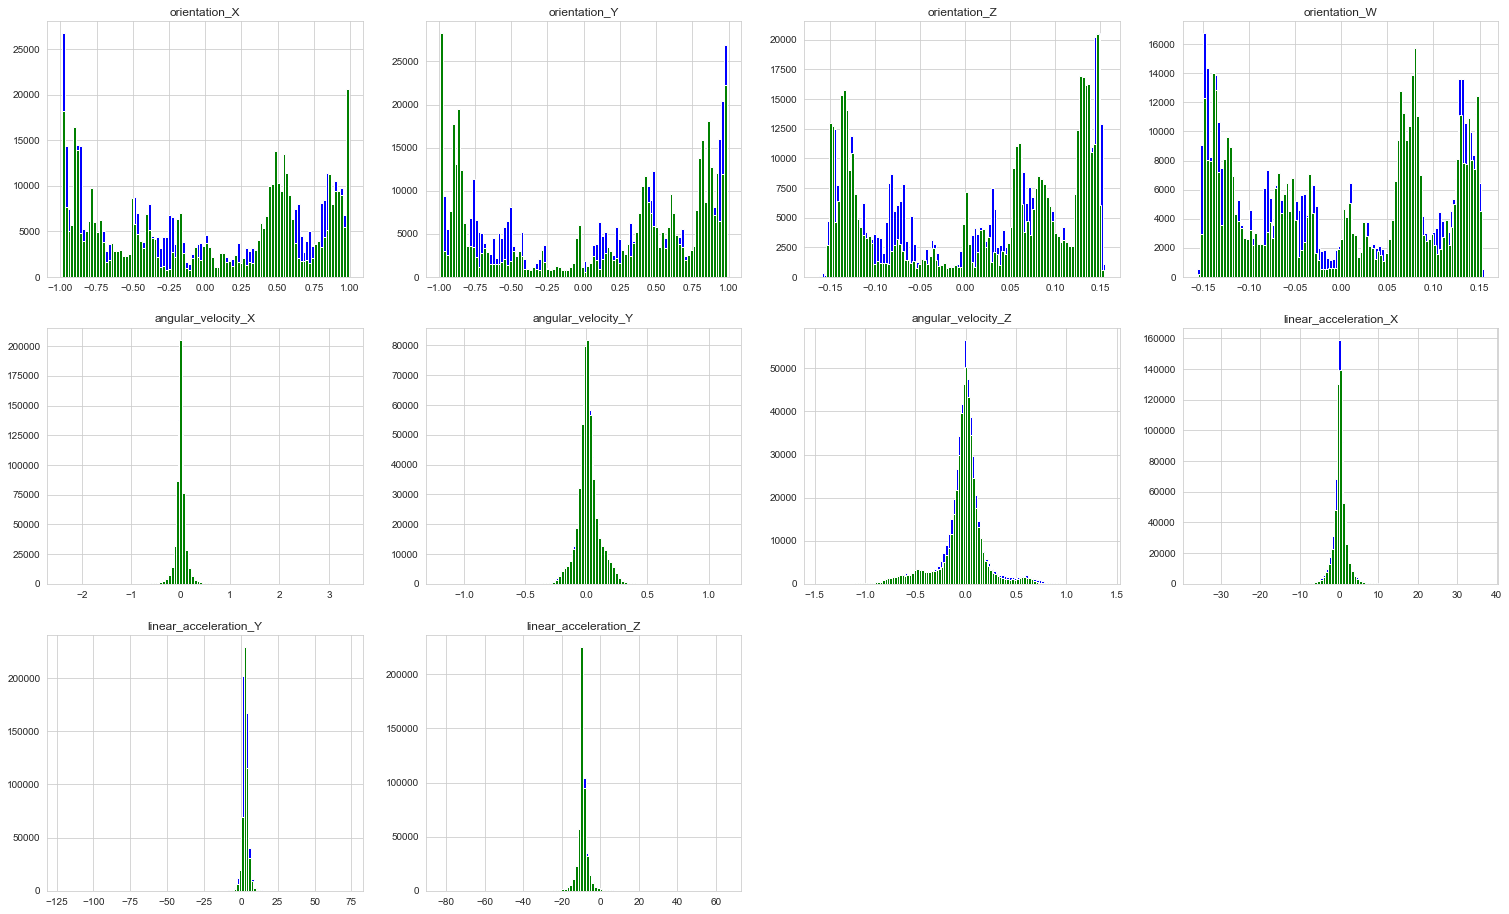

In [69]:
# histogram of each of the series variables for both train and test data
# code from https://www.kaggle.com/artgor/where-do-the-robots-drive
plt.figure(figsize=(26, 16))
for i, col in enumerate(data_train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(data_train[col], color='blue', bins=100)
    plt.hist(data_test[col], color='green', bins=100)
    plt.title(col)
plt.show()

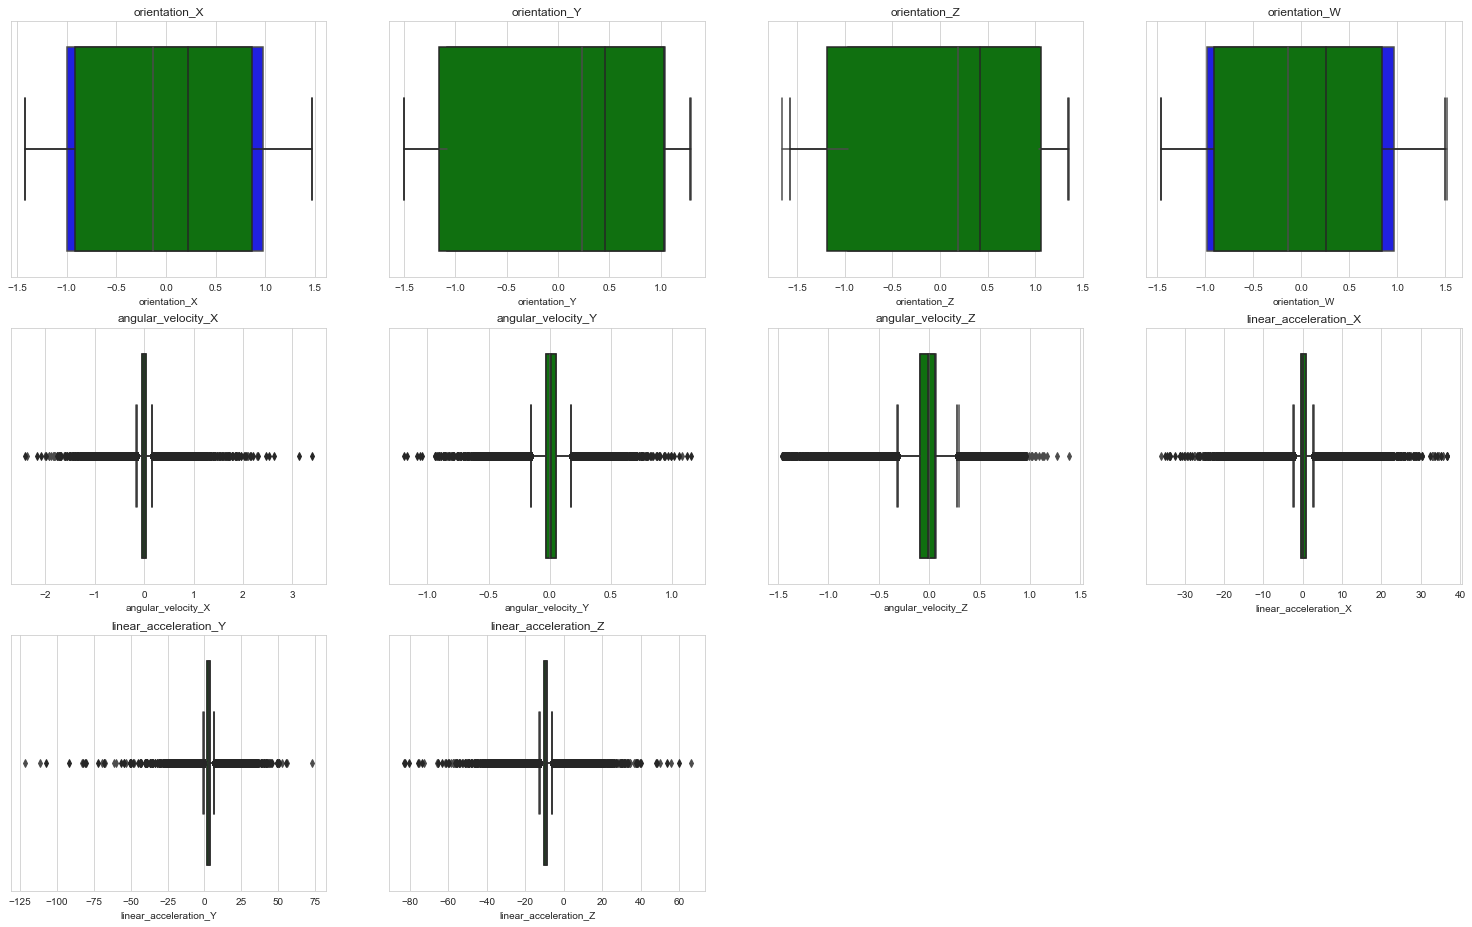

In [74]:
# boxplots of train and test data 
plt.figure(figsize=(26, 16))
for i, col in enumerate(data_train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data_train[col],color='blue')
    sns.boxplot(data_test[col], color='green')
    plt.title(col)
plt.show()

C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


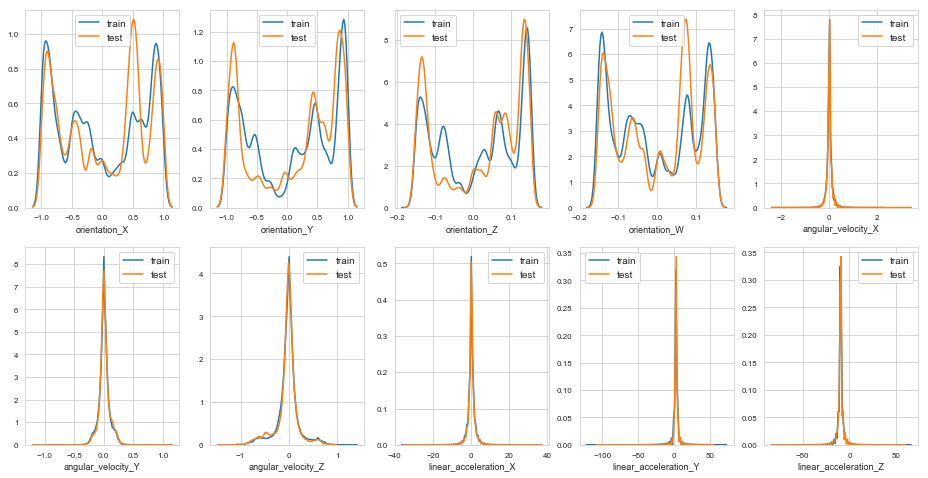

In [52]:
# Density plots of  train and test data
#https://www.kaggle.com/gpreda/robots-need-help
features = data_train.columns.values[3:13]
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,5,figsize=(16,8))

for feature in features:
    i += 1
    plt.subplot(2,5,i)
    sns.distplot(data_train[feature], hist=False, label='train')
    sns.distplot(data_test[feature], hist=False, label='test')
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
plt.show();

surface type is  507    fine_concrete
Name: surface, dtype: object


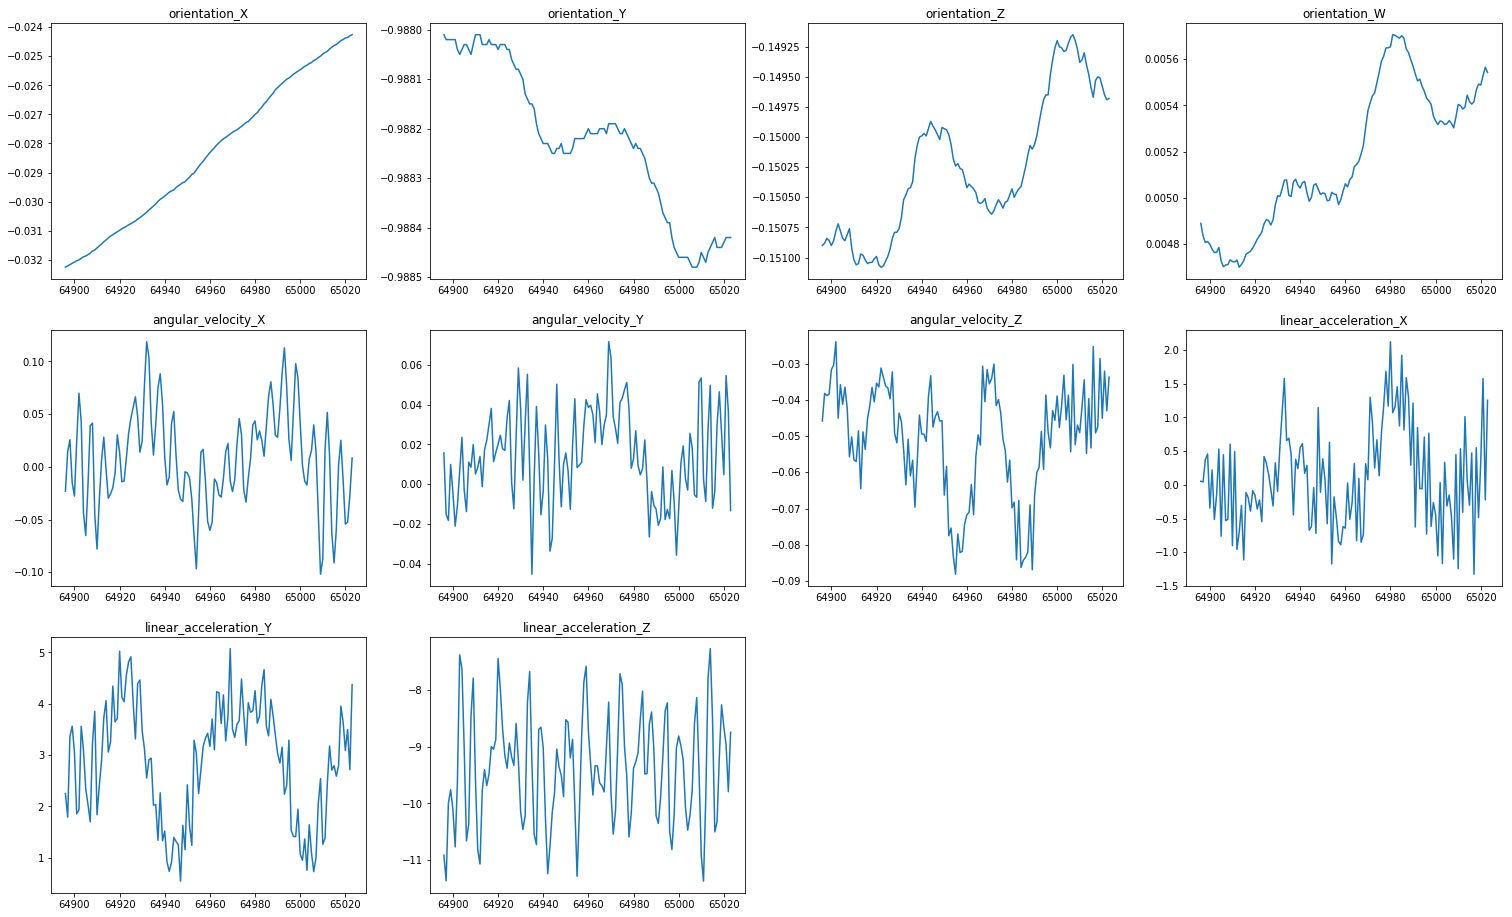

In [39]:
#sample data plots
s = (data_train['series_id'] == 507)
print('surface type is ', y_train['surface'][y_train['series_id']==507])
plt.figure(figsize = (26,16))
for i, col in enumerate(data_train.columns[3:]):
    plt.subplot(3,4,i+1)
    plt.plot(data_train.loc[s,col])
    plt.title(col)
plt.show()

In [ ]:
# join data and surface based on series_id so that we can plot 
# variables based on surfaces
Xy_train = data_train.join(y_train['surface'], on='series_id')
print('shape of joined data ',Xy_train.shape)
Xy_train.head()

C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


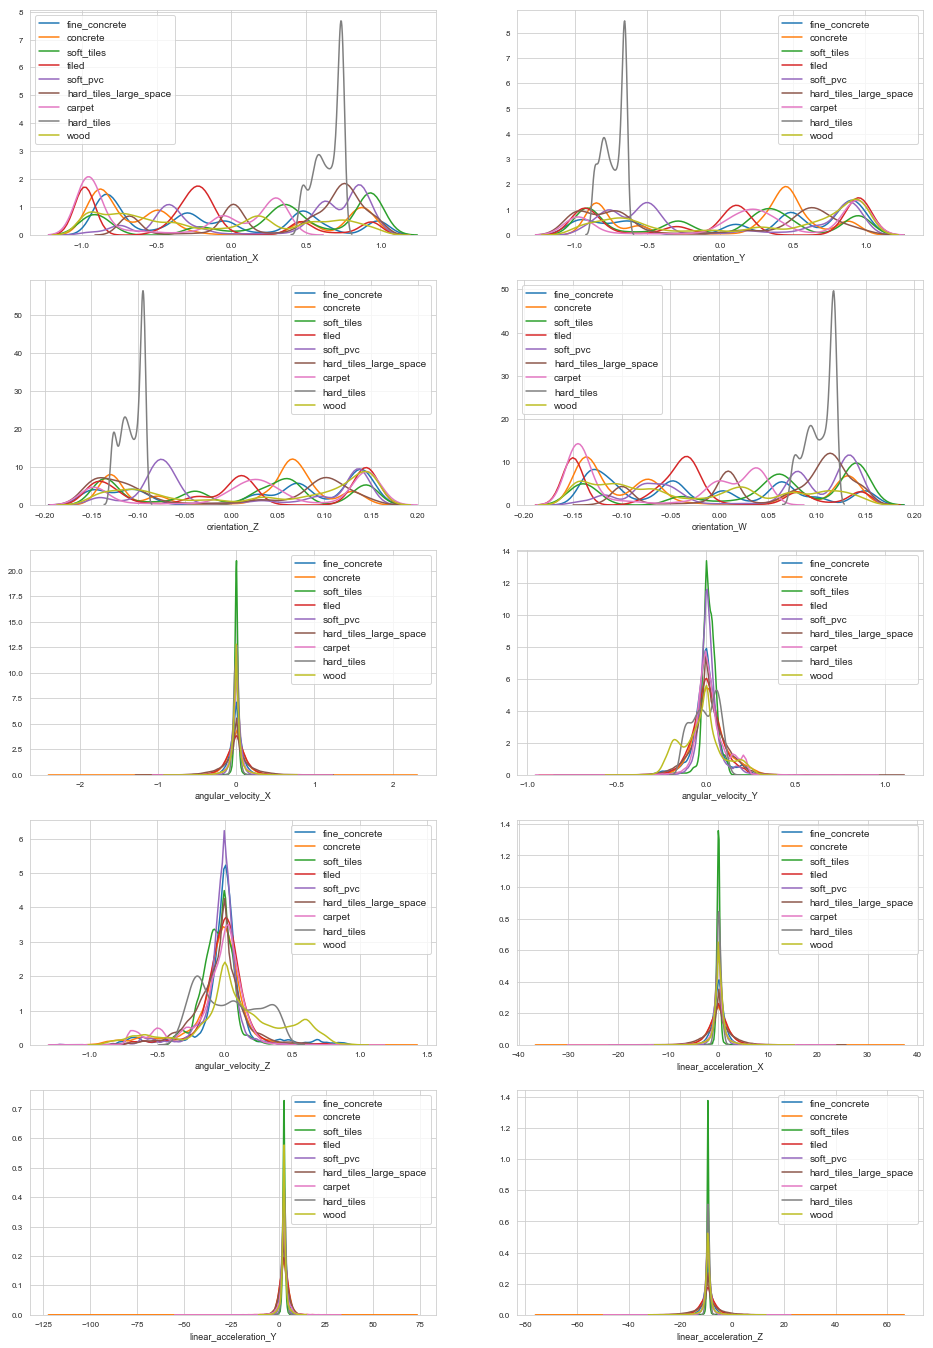

In [57]:
# density plots of each variable and each surface
#https://www.kaggle.com/gpreda/robots-need-help
classes = (y_train['surface'].unique())
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(5,2,figsize=(16,24))

for feature in features:
    i += 1
    plt.subplot(5,2,i)
    for clas in classes:
        ttc = Xy_train[Xy_train['surface']==clas]
        sns.distplot(ttc[feature], hist=False,label=clas)
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
plt.show();

In [43]:
# random sampled series plot of velocity and acceleration variables

#random.seed(32) #wood:3, soft_tiles:2, fine_concrete:2, tiled:2, hard_tiles_large_space:1
#random.seed(41)  #wood:1, soft_pvc:1, concrete: 4, tiled:2, fine_concrete:1, hard_tiles_large_space:1
random.seed(27)
sample_series = random.sample(range(0,3810),10)
sample_df = Xy_train[Xy_train['series_id'] == sample_series[0]]
for k in sample_series[1:]:
    result = pd.concat([sample_df, Xy_train[Xy_train['series_id'] == k]])
    sample_df = result
print('sample shape : ',sample_df.shape)
sample_df['surface'].value_counts()

shape of joined data  (487680, 14)
sample shape :  (1280, 14)


soft_pvc                  512
fine_concrete             128
carpet                    128
wood                      128
hard_tiles                128
hard_tiles_large_space    128
concrete                  128
Name: surface, dtype: int64

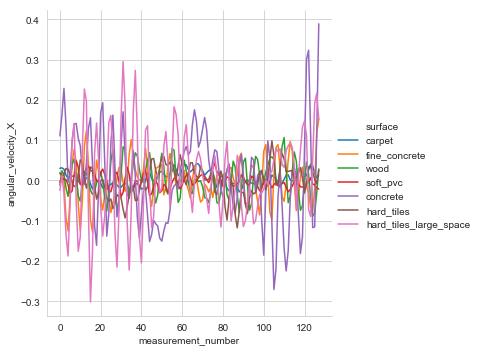

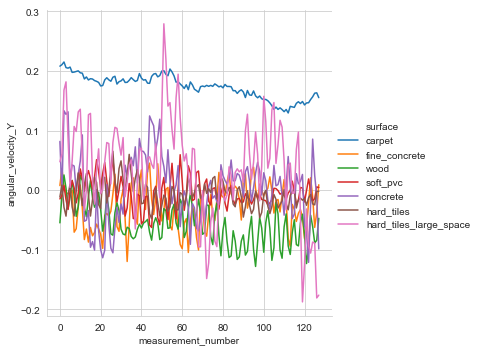

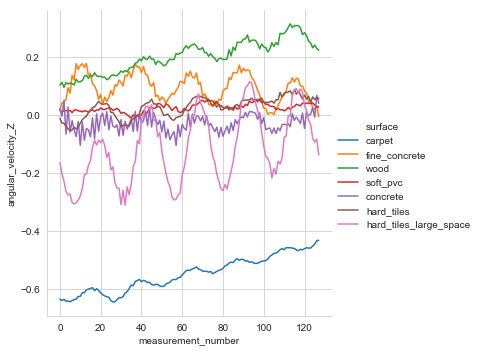

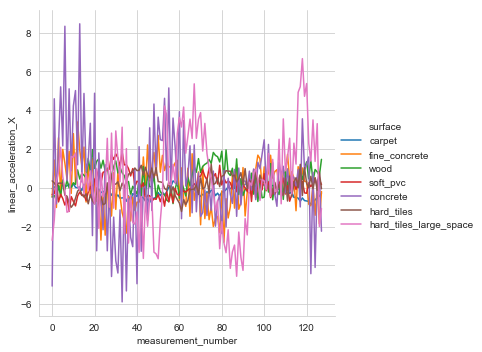

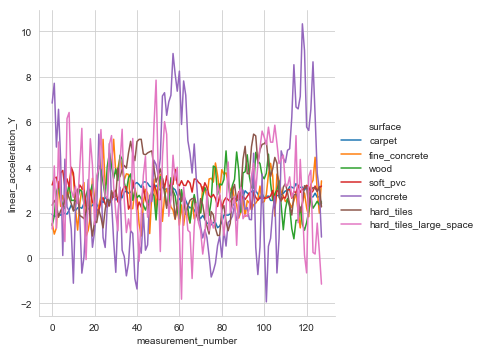

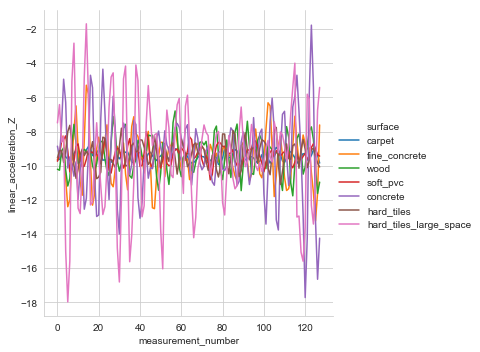

In [66]:
# plots of randomly samples series
sns.set_style('whitegrid')
plt.figure()
sns.relplot(x='measurement_number', y='angular_velocity_X', kind='line', hue = 'surface', ci=None, data=sample_df)
sns.relplot(x='measurement_number', y='angular_velocity_Y', kind='line', hue = 'surface', ci=None, data=sample_df)
sns.relplot(x='measurement_number', y='angular_velocity_Z', kind='line', hue = 'surface', ci=None, data=sample_df)
sns.relplot(x='measurement_number', y='linear_acceleration_X', kind='line', hue = 'surface', ci=None, data=sample_df)
sns.relplot(x='measurement_number', y='linear_acceleration_Y', kind='line', hue = 'surface', ci=None, data=sample_df)
sns.relplot(x='measurement_number', y='linear_acceleration_Z', kind='line', hue = 'surface', ci=None, data=sample_df)
plt.show()

In [73]:
# from the above we observe that orientation variables where spread
# we scale the variables by z-normalize
# code from https://www.kaggle.com/artgor/where-do-the-robots-drive

for col in data_train.columns:
    # rescale orientation variables only
    if 'orient' in col:
        scaler = StandardScaler()
        data_train[col] = scaler.fit_transform(data_train[col].values.reshape(-1, 1))
        data_test[col] = scaler.transform(data_test[col].values.reshape(-1, 1))


Preparing data for convolutional neural networks we need to reshape the data to a three-dimensional array.
We do this for the full data and the also grouping orientation, velocity and acceleration variables separately.

In [75]:
#use pd.DataFrame.groupby to group by series_id and collect important variables
tr = np.array([x.values[:,3:] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_orient = np.array([x.values[:,3:7] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_velocity = np.array([x.values[:,7:10] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_acceler = np.array([x.values[:,10:13] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_vel_acc = np.array([x.values[:,7:13] for group,x in data_train.groupby('series_id')], dtype='float32')
print('shape of tr_orient ', tr_orient.shape)

In [152]:
# reshape test data as above
ts = np.array([x.values[:,3:] for group,x in data_test.groupby('series_id')], dtype='float32')
ts.shape
ts_orient = np.array([x.values[:,3:7] for group,x in data_test.groupby('series_id')], dtype='float32')
ts_velocity = np.array([x.values[:,7:10] for group,x in data_test.groupby('series_id')], dtype='float32')
ts_acceler = np.array([x.values[:,10:13] for group,x in data_test.groupby('series_id')], dtype='float32')
ts_vel_acc = np.array([x.values[:,7:13] for group,x in data_test.groupby('series_id')], dtype='float32')

In [100]:
seed = 27
np.random.seed(seed)

num_classes = len(np.unique(y_train['surface']))

# labeling the surfaces with integers
le = LabelEncoder()
targets = le.fit_transform(y_train['surface'])

# one-hot encode the labels
targets_enc = np_utils.to_categorical(targets, num_classes)


9
(3810,)


In [130]:
# model architecture
def TemporalCNN():
    input_orient = Input(shape=(128,4))
    input_velocity = Input(shape=(128,3))
    input_acceler = Input(shape=(128,3))
    
    padding = 'same'
    
    o = Conv1D(filters=16, kernel_size=5, padding=padding, kernel_initializer='lecun_uniform', 
               activation = 'relu')(input_orient)
    o = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(o)
    o = AveragePooling1D(pool_size=2)(o)
    o = BatchNormalization()(o)
    o = Conv1D(filters=64, kernel_size=5, padding=padding, activation = 'relu')(o)
    o = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(o)
    o = AveragePooling1D(pool_size=2)(o)
    o = BatchNormalization()(o)

    v = Conv1D(filters=16, kernel_size=5, padding=padding, kernel_initializer='lecun_uniform', 
               activation = 'relu')(input_velocity)
    v = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(v)
    v = AveragePooling1D(pool_size=2)(v)
    v = BatchNormalization()(v)
    v = Conv1D(filters=64, kernel_size=5, padding=padding, activation = 'relu')(v)
    v = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(v)
    v = AveragePooling1D(pool_size=2)(v)
    v = BatchNormalization()(v)

    a = Conv1D(filters=16, kernel_size=5, padding=padding, kernel_initializer='lecun_uniform', 
               activation = 'relu')(input_acceler)
    a = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(a)
    a = AveragePooling1D(pool_size=2)(a)
    a = BatchNormalization()(a)
    a = Conv1D(filters=64, kernel_size=5, padding=padding, activation = 'relu')(a)
    a = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(a)
    a = AveragePooling1D(pool_size=2)(a)
    a = BatchNormalization()(a)

    merge = keras.layers.concatenate([o,v,a])

    m = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(merge)
    m = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(m)
    m = AveragePooling1D(pool_size=2)(m)
    m = BatchNormalization()(m)
    m = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(m)
    m = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(m)
    m = BatchNormalization()(m)
    m = GlobalAveragePooling1D()(m)
    output = Dense(9, activation='softmax')(m)

    new_model = Model(inputs = [input_orient,input_velocity,input_acceler], outputs = output)

    #new_model.summary()

    new_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0005), 
                      metrics=['accuracy'])

    
    return new_model

In [132]:
# Here we run the learning phase
# I use cross-validation using 5 folds 

# setting epochs and batch size
epochs = 60
batch_size = 15

#store model, history of epochs, scores and predictions on validatioin folds
models_pack=[]
hist_pack = []
scores=[]
pred_val = np.zeros((targets.shape[0],9))

# we stratify so that each fold has at similar distribution
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
for train_index, valid_index in skf.split(tr, targets):
    X_train, X_valid = tr[train_index], tr[valid_index]
    y_train, y_valid = targets_enc[train_index], targets_enc[valid_index]
    orient_train, orient_valid = tr_orient[train_index], tr_orient[valid_index]
    velocity_train, velocity_valid = tr_velocity[train_index], tr_velocity[valid_index]
    acceler_train, acceler_valid = tr_acceler[train_index], tr_acceler[valid_index]
    input_train = [orient_train,velocity_train, acceler_train]
    target_train = y_train
    input_test  = [orient_valid,velocity_valid,acceler_valid]
    target_test = y_valid
    
    model = TemporalCNN()
    
    hist = model.fit([orient_train,velocity_train, acceler_train], y_train, batch_size=batch_size, epochs=epochs,
               validation_data = ([orient_valid,velocity_valid,acceler_valid], y_valid), verbose=2)
    
    score = model.evaluate([orient_valid, velocity_valid,acceler_valid], y_valid, verbose=0)
    
    pred_val[valid_index,:]=model.predict([orient_valid, velocity_valid,acceler_valid])
    predictions = new_model.predict([orient_valid, velocity_valid,acceler_valid])
    predictions = [np.argmax(entry) for entry in predictions]

    labels = [np.argmax(vector) for vector in y_valid]
    display(confusion_matrix(labels, predictions))
    
    scores.append(score)
    models_pack.append(model)
    hist_pack.append(hist)

Train on 3044 samples, validate on 766 samples
Epoch 1/60
 - 68s - loss: 1.4655 - acc: 0.5161 - val_loss: 1.1716 - val_acc: 0.6031
Epoch 2/60
 - 21s - loss: 1.1414 - acc: 0.6032 - val_loss: 0.9028 - val_acc: 0.6802
Epoch 3/60
 - 19s - loss: 1.0067 - acc: 0.6551 - val_loss: 0.8475 - val_acc: 0.6984
Epoch 4/60
 - 19s - loss: 0.8817 - acc: 0.6948 - val_loss: 0.8149 - val_acc: 0.7141
Epoch 5/60
 - 20s - loss: 0.8289 - acc: 0.7089 - val_loss: 1.0032 - val_acc: 0.6593
Epoch 6/60
 - 20s - loss: 0.7897 - acc: 0.7198 - val_loss: 0.8439 - val_acc: 0.7219
Epoch 7/60
 - 20s - loss: 0.7047 - acc: 0.7556 - val_loss: 0.5921 - val_acc: 0.8081
Epoch 8/60
 - 19s - loss: 0.6888 - acc: 0.7579 - val_loss: 0.6263 - val_acc: 0.7637
Epoch 9/60
 - 20s - loss: 0.6247 - acc: 0.7835 - val_loss: 0.5838 - val_acc: 0.7950
Epoch 10/60
 - 19s - loss: 0.6050 - acc: 0.7888 - val_loss: 0.6362 - val_acc: 0.7755
Epoch 11/60
 - 20s - loss: 0.5800 - acc: 0.7898 - val_loss: 0.5449 - val_acc: 0.8211
Epoch 12/60
 - 19s - loss: 

array([[ 30,   4,   0,   0,   1,   0,   2,   0,   1],
       [  1, 139,   2,   0,   1,   7,   1,   1,   4],
       [  1,   1,  60,   0,   1,   6,   0,   2,   2],
       [  0,   0,   0,   3,   0,   1,   0,   0,   1],
       [  0,   1,   1,   0,  60,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 135,   3,   4,   5],
       [  0,   0,   0,   0,   0,   0,  59,   0,   1],
       [  1,   2,   1,   0,   0,   1,   0,  98,   0],
       [  2,   4,   1,   0,   0,   5,   2,   0, 108]], dtype=int64)

Train on 3045 samples, validate on 765 samples
Epoch 1/60
 - 70s - loss: 1.4706 - acc: 0.5120 - val_loss: 1.1424 - val_acc: 0.6405
Epoch 2/60
 - 25s - loss: 1.1180 - acc: 0.6210 - val_loss: 0.9366 - val_acc: 0.6641
Epoch 3/60
 - 20s - loss: 0.9636 - acc: 0.6581 - val_loss: 0.8568 - val_acc: 0.6941
Epoch 4/60
 - 20s - loss: 0.8746 - acc: 0.6903 - val_loss: 0.8658 - val_acc: 0.7072
Epoch 5/60
 - 19s - loss: 0.8099 - acc: 0.7146 - val_loss: 0.8202 - val_acc: 0.6928
Epoch 6/60
 - 20s - loss: 0.7479 - acc: 0.7402 - val_loss: 0.7686 - val_acc: 0.7438
Epoch 7/60
 - 20s - loss: 0.7357 - acc: 0.7396 - val_loss: 0.6155 - val_acc: 0.7804
Epoch 8/60
 - 20s - loss: 0.6908 - acc: 0.7534 - val_loss: 0.7903 - val_acc: 0.7176
Epoch 9/60
 - 20s - loss: 0.6279 - acc: 0.7701 - val_loss: 0.9286 - val_acc: 0.7150
Epoch 10/60
 - 20s - loss: 0.5902 - acc: 0.7905 - val_loss: 0.5818 - val_acc: 0.8118
Epoch 11/60
 - 20s - loss: 0.5766 - acc: 0.7924 - val_loss: 0.7591 - val_acc: 0.7438
Epoch 12/60
 - 20s - loss: 

array([[ 32,   3,   0,   0,   0,   0,   1,   0,   2],
       [  3, 137,   2,   0,   1,   7,   1,   1,   4],
       [  1,   4,  63,   0,   0,   0,   0,   3,   2],
       [  0,   0,   0,   1,   0,   0,   0,   0,   3],
       [  2,   3,   0,   0,  54,   0,   0,   0,   3],
       [  1,   2,   0,   0,   0, 134,   5,   0,   5],
       [  1,   0,   0,   0,   0,   0,  58,   0,   1],
       [  1,   3,   1,   0,   1,   3,   0,  94,   0],
       [  2,   2,   4,   0,   1,   6,   1,   0, 106]], dtype=int64)

Train on 3048 samples, validate on 762 samples
Epoch 1/60
 - 73s - loss: 1.4790 - acc: 0.5013 - val_loss: 1.2838 - val_acc: 0.5722
Epoch 2/60
 - 27s - loss: 1.1471 - acc: 0.6001 - val_loss: 1.0285 - val_acc: 0.6234
Epoch 3/60
 - 22s - loss: 0.9825 - acc: 0.6640 - val_loss: 0.9805 - val_acc: 0.6614
Epoch 4/60
 - 21s - loss: 0.8911 - acc: 0.6854 - val_loss: 1.3379 - val_acc: 0.5236
Epoch 5/60
 - 21s - loss: 0.8523 - acc: 0.6978 - val_loss: 0.8547 - val_acc: 0.6995
Epoch 6/60
 - 21s - loss: 0.7535 - acc: 0.7274 - val_loss: 1.0528 - val_acc: 0.6483
Epoch 7/60
 - 21s - loss: 0.7628 - acc: 0.7320 - val_loss: 0.9414 - val_acc: 0.6916
Epoch 8/60
 - 20s - loss: 0.6763 - acc: 0.7484 - val_loss: 0.7887 - val_acc: 0.6969
Epoch 9/60
 - 21s - loss: 0.6244 - acc: 0.7841 - val_loss: 0.7591 - val_acc: 0.7480
Epoch 10/60
 - 20s - loss: 0.6465 - acc: 0.7700 - val_loss: 1.1183 - val_acc: 0.6102
Epoch 11/60
 - 21s - loss: 0.6156 - acc: 0.7697 - val_loss: 1.0333 - val_acc: 0.7192
Epoch 12/60
 - 20s - loss: 

array([[ 29,   4,   0,   0,   0,   3,   0,   0,   2],
       [  0, 139,   4,   0,   2,   7,   1,   2,   1],
       [  0,   1,  60,   1,   0,   6,   0,   0,   5],
       [  0,   0,   0,   2,   0,   0,   1,   0,   1],
       [  2,   2,   0,   0,  57,   0,   0,   0,   1],
       [  0,   5,   0,   0,   0, 135,   1,   0,   5],
       [  0,   0,   0,   0,   0,   0,  59,   0,   0],
       [  1,   6,   4,   0,   0,   1,   3,  87,   1],
       [  2,   1,   1,   0,   0,   4,   0,   2, 111]], dtype=int64)

Train on 3050 samples, validate on 760 samples
Epoch 1/60
 - 74s - loss: 1.4533 - acc: 0.5207 - val_loss: 1.2680 - val_acc: 0.5776
Epoch 2/60
 - 36s - loss: 1.1223 - acc: 0.6174 - val_loss: 1.0138 - val_acc: 0.6697
Epoch 3/60
 - 35s - loss: 1.0208 - acc: 0.6452 - val_loss: 1.1059 - val_acc: 0.6013
Epoch 4/60
 - 30s - loss: 0.9130 - acc: 0.6787 - val_loss: 0.8261 - val_acc: 0.7263
Epoch 5/60
 - 37s - loss: 0.8477 - acc: 0.6911 - val_loss: 0.9888 - val_acc: 0.6684
Epoch 6/60
 - 26s - loss: 0.7913 - acc: 0.7184 - val_loss: 0.7814 - val_acc: 0.7474
Epoch 7/60
 - 29s - loss: 0.7825 - acc: 0.7200 - val_loss: 0.7484 - val_acc: 0.7461
Epoch 8/60
 - 31s - loss: 0.7499 - acc: 0.7321 - val_loss: 0.6708 - val_acc: 0.7737
Epoch 9/60
 - 32s - loss: 0.6939 - acc: 0.7554 - val_loss: 0.6498 - val_acc: 0.7697
Epoch 10/60
 - 21s - loss: 0.6332 - acc: 0.7692 - val_loss: 0.6772 - val_acc: 0.7618
Epoch 11/60
 - 28s - loss: 0.6155 - acc: 0.7764 - val_loss: 0.7579 - val_acc: 0.7250
Epoch 12/60
 - 31s - loss: 

array([[ 32,   4,   0,   0,   0,   2,   0,   0,   0],
       [  0, 142,   1,   0,   0,   5,   4,   1,   3],
       [  0,   2,  59,   0,   1,   6,   0,   0,   4],
       [  0,   0,   0,   3,   0,   0,   1,   0,   0],
       [  0,   1,   1,   0,  58,   0,   0,   0,   1],
       [  0,   1,   1,   0,   1, 133,   1,   2,   7],
       [  0,   0,   0,   1,   0,   0,  58,   0,   0],
       [  1,   5,   1,   0,   0,   2,   2,  90,   2],
       [  0,   2,   4,   0,   0,   4,   0,   5, 106]], dtype=int64)

Train on 3053 samples, validate on 757 samples
Epoch 1/60
 - 80s - loss: 1.5031 - acc: 0.5074 - val_loss: 1.2146 - val_acc: 0.5984
Epoch 2/60
 - 39s - loss: 1.1453 - acc: 0.6024 - val_loss: 0.9816 - val_acc: 0.6737
Epoch 3/60
 - 23s - loss: 0.9577 - acc: 0.6564 - val_loss: 0.8626 - val_acc: 0.6988
Epoch 4/60
 - 22s - loss: 0.8866 - acc: 0.6842 - val_loss: 0.8511 - val_acc: 0.7239
Epoch 5/60
 - 21s - loss: 0.8040 - acc: 0.7177 - val_loss: 0.8882 - val_acc: 0.6856
Epoch 6/60
 - 22s - loss: 0.7563 - acc: 0.7367 - val_loss: 0.7010 - val_acc: 0.7464
Epoch 7/60
 - 41s - loss: 0.7140 - acc: 0.7566 - val_loss: 0.6976 - val_acc: 0.7398
Epoch 8/60
 - 40s - loss: 0.6637 - acc: 0.7668 - val_loss: 0.6952 - val_acc: 0.7318
Epoch 9/60
 - 23s - loss: 0.6163 - acc: 0.7815 - val_loss: 0.7243 - val_acc: 0.7252
Epoch 10/60
 - 32s - loss: 0.5863 - acc: 0.7904 - val_loss: 0.7792 - val_acc: 0.7173
Epoch 11/60
 - 33s - loss: 0.5705 - acc: 0.7904 - val_loss: 1.1153 - val_acc: 0.6618
Epoch 12/60
 - 36s - loss: 

array([[ 33,   2,   0,   0,   0,   1,   0,   0,   1],
       [  1, 140,   4,   0,   1,   4,   2,   2,   1],
       [  0,   2,  49,   0,   2,   6,   0,   2,  11],
       [  0,   0,   0,   3,   0,   0,   1,   0,   0],
       [  2,   1,   1,   0,  55,   0,   0,   0,   2],
       [  0,   1,   0,   0,   0, 132,   3,   0,  10],
       [  0,   0,   0,   1,   0,   1,  56,   0,   1],
       [  0,   4,   1,   0,   0,   2,   1,  94,   0],
       [  3,   4,   2,   0,   0,   4,   0,   7, 101]], dtype=int64)

In [133]:
np.array(scores)[:,1]

array([0.84334204, 0.83006536, 0.8175853 , 0.86447368, 0.80977543])

In [135]:
targets.shape[0]

3810

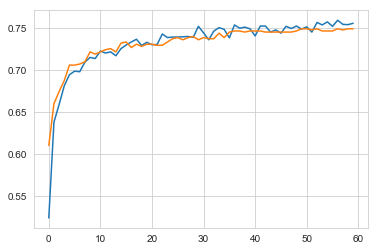

In [117]:
plt.figure()
plt.subplots(3,2, figsize=(16,8))
for i, hist in enumerate(hist_pack):
    plt.subplot(3,2,i)
    plt.plot(hist.history['acc'], label='train')
    plt.plot(hist.history['val_acc'], label='valid')
plt.show()

In [151]:
#for i, model in enumerate(models_pack):
#    model = models_pack[i]
#    model.save('model'+str(i)+'gpr_1.h5')

In [162]:
# predicting surfaces of test data
yhats = [model.predict([ts_orient, ts_velocity, ts_acceler]) for model in models_pack]
#save it as an array
yhats = np.array(yhats)
#check shape (5, 3810, 9)
print('yhats shape : ',yhats.shape)
#sum probabilities from 5 folds for each series and surface
summed = np.sum(yhats, axis=0)
#get the surface with highest frequency voted by 5 folds
y_test_pred = np.argmax(summed, axis=1)
# saving results to submit to Kaggle competition 
submission = pd.read_csv('sample_submission.csv')
submission['surface'] = le.inverse_transform(y_test_pred)
submission.to_csv('submission_cnn.csv', index=False)
submission.head(20)

In [ ]:
predictions = np.argmax(pred_val,axis=1)
print('accuracy score ',accuracy_score(predictions,targets))
print('F1 score by weighting classes "macro" :',f1_score(predictions, targets, average='macro'))
display(confusion_matrix(predictions, targets))

In [150]:
# perfect fit.
display(confusion_matrix(targets, targets))

array([[189,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 779,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 363,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  21,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 308,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 732,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 297,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 514,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 607]], dtype=int64)

In [124]:
np.array(scores)[:,1]

array([0.76501305, 0.77908497, 0.74934383, 0.77631579, 0.77146631])